In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random

from pathlib import Path

import matplotlib.pyplot as plt
import motorlab as ml
import numpy as np
import plotly.graph_objects as go
import umap
import yaml

In [3]:
os.chdir(Path().resolve().parent)

In [5]:
sessions = [
    "bex_20230621_spikes_sorted_SES",  # before
    "bex_20230624_spikes_sorted_SES",  # before
    "bex_20230629_spikes_sorted_SES",  # before
    "bex_20230630_spikes_sorted_SES",  # before
    "bex_20230701_spikes_sorted_SES",  # before
    "bex_20230708_spikes_sorted_SES",  # while
    # "ken_20230614_spikes_sorted_SES",  # while and before
    "ken_20230618_spikes_sorted_SES",  # before
    "ken_20230622_spikes_sorted_SES",  # while, before and free
    "ken_20230629_spikes_sorted_SES",  # while, before and free
    "ken_20230630_spikes_sorted_SES",  # while
    "ken_20230701_spikes_sorted_SES",  # before
    "ken_20230703_spikes_sorted_SES",  # while
]

In [12]:
speeds = {session: {"L": [], "R": []} for session in sessions}
trial_lengths = {session: {"L": [], "R": []} for session in sessions}
y_axis_com = {session: {"L": [], "R": []} for session in sessions}
ego_poses_dict = {session: {"L": [], "R": []} for session in sessions}

for i, session in enumerate(sessions):
    TRIALS_DIR = Path(f"data/gbyk/{session}/trials/")
    POSES_DIR = Path(f"data/gbyk/{session}/poses/")
    raw_poses = ml.data.load_from_memmap(POSES_DIR)
    ego_poses = ml.poses.change_repr(raw_poses, "gbyk", "egocentric")
    com = ml.poses.compute_com(raw_poses, "gbyk")

    for trial in TRIALS_DIR.iterdir():
        with trial.open() as f:
            meta_trial = yaml.safe_load(f)
            start = int(meta_trial["first_frame_idx"] // 50)
            end = start + int(meta_trial["num_frames"] // 50)

            if meta_trial["choice"] == "L":
                speeds[session]["L"].append(
                    np.diff(com[start - 1 : end], axis=0)
                )
                y_axis_com[session]["L"].append(com[start:end, 1])
                ego_poses_dict[session]["L"].append(ego_poses[start:end])
                trial_lengths[session]["L"].append(end - start)
            elif meta_trial["choice"] == "R":
                speeds[session]["R"].append(
                    np.diff(com[start - 1 : end], axis=0)
                )
                y_axis_com[session]["R"].append(com[start:end, 1])
                ego_poses_dict[session]["R"].append(ego_poses[start:end])
                trial_lengths[session]["R"].append(end - start)

In [ ]:
nrows = len(sessions) // 2
ncols = 2
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    sharex=True,
    sharey=True,
    figsize=(8 * ncols, 4 * nrows),
)

for i, session in enumerate(sessions):
    axs[i // 2, i % 2].set_title(session)
    for c, y in zip(speeds[session]["L"], y_axis_com[session]["L"]):
        axs[i // 2, i % 2].plot(y, c[:, 1], color="red", lw=0.5)
    for c, y in zip(speeds[session]["R"], y_axis_com[session]["R"]):
        axs[i // 2, i % 2].plot(
            y,
            c[:, 1],
            color="blue",
            lw=0.5,
        )

In [ ]:
nrows = len(sessions) // 2
ncols = 2
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    sharex=True,
    sharey=True,
    figsize=(8 * ncols, 4 * nrows),
)

for i, session in enumerate(sessions):
    right_stacked = np.concatenate(speeds[session]["R"], axis=0)[:, 1]
    left_stacked = np.concatenate(speeds[session]["L"], axis=0)[:, 1]
    axs[i // 2, i % 2].set_title(session)
    axs[i // 2, i % 2].hist(
        right_stacked,
        bins=100,
        color="blue",
        alpha=0.5,
        density=True,
    )
    axs[i // 2, i % 2].hist(
        left_stacked,
        bins=100,
        color="red",
        alpha=0.5,
        density=True,
    )

In [ ]:
ego_poses_left = {
    session: np.concatenate(ego_poses_dict[session]["L"], axis=0)
    for session in sessions
}
ego_poses_right = {
    session: np.concatenate(ego_poses_dict[session]["R"], axis=0)
    for session in sessions
}
y_axis_com_left = {
    session: np.concatenate(y_axis_com[session]["L"], axis=0)
    for session in sessions
}
y_axis_com_right = {
    session: np.concatenate(y_axis_com[session]["R"], axis=0)
    for session in sessions
}
ego_poses_stacked = {
    session: np.concatenate(
        [ego_poses_left[session], ego_poses_right[session]], axis=0
    )
    for session in sessions
}
y_axis_com_stacked = {
    session: np.concatenate(
        [y_axis_com_left[session], y_axis_com_right[session]], axis=0
    )
    for session in sessions
}
l_limits = {session: ego_poses_left[session].shape[0] for session in sessions}

In [59]:
n_dims = 5
reducer = umap.UMAP(n_components=n_dims, random_state=0)
embeddings = {
    session: reducer.fit_transform(ego_poses_stacked[session])
    for session in sessions
}

/Users/caio/dev/motorlab/.mlab/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


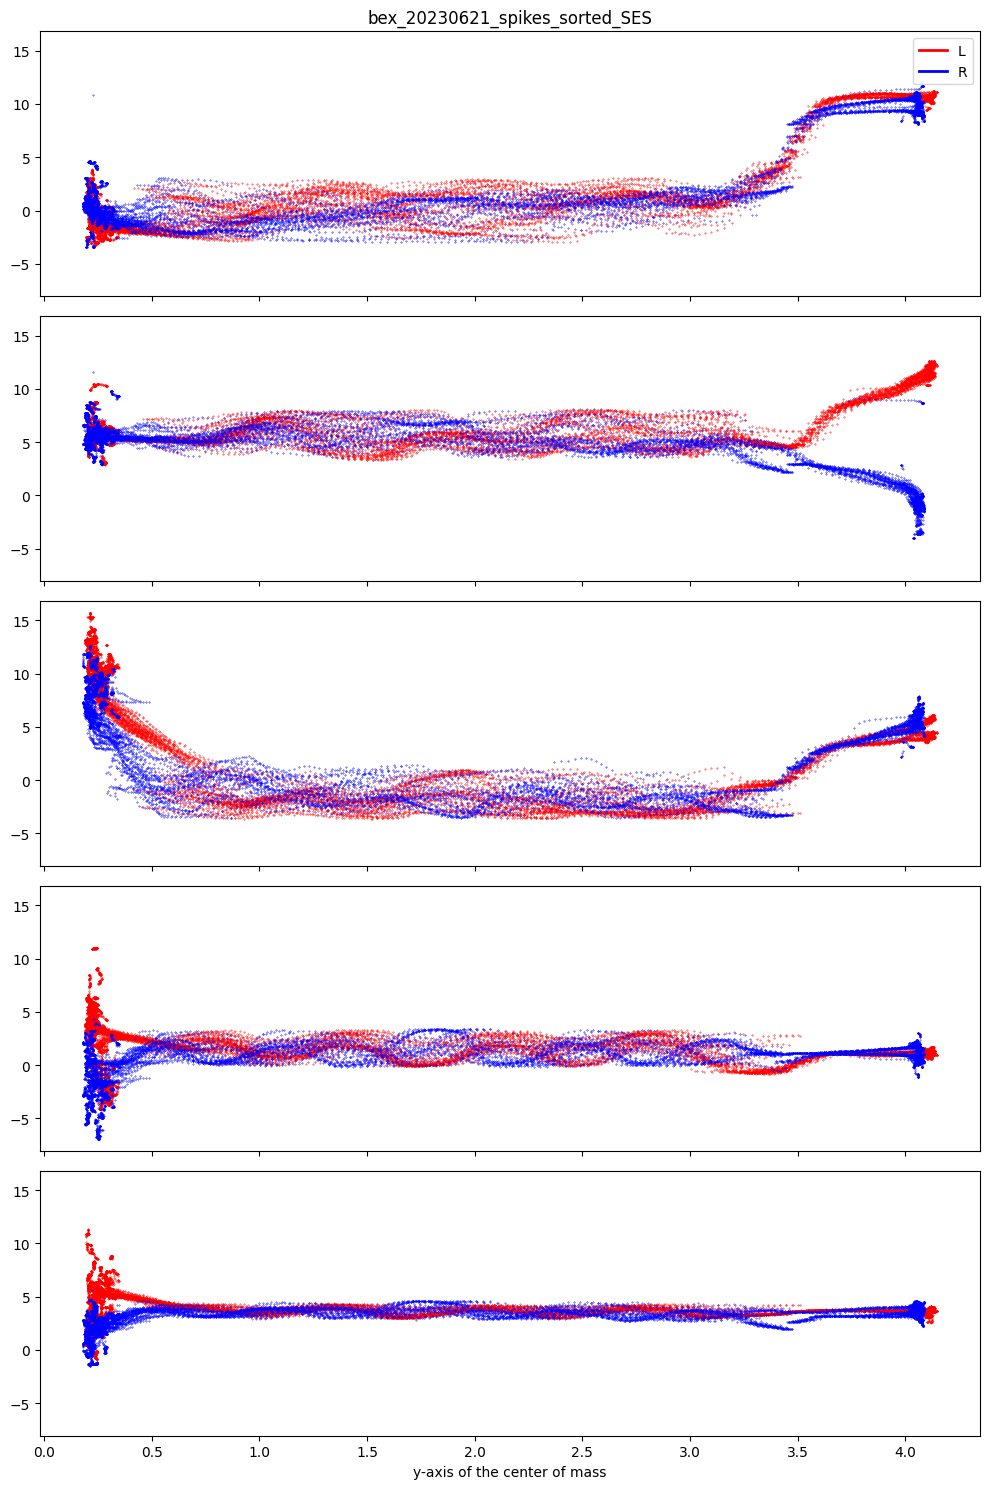

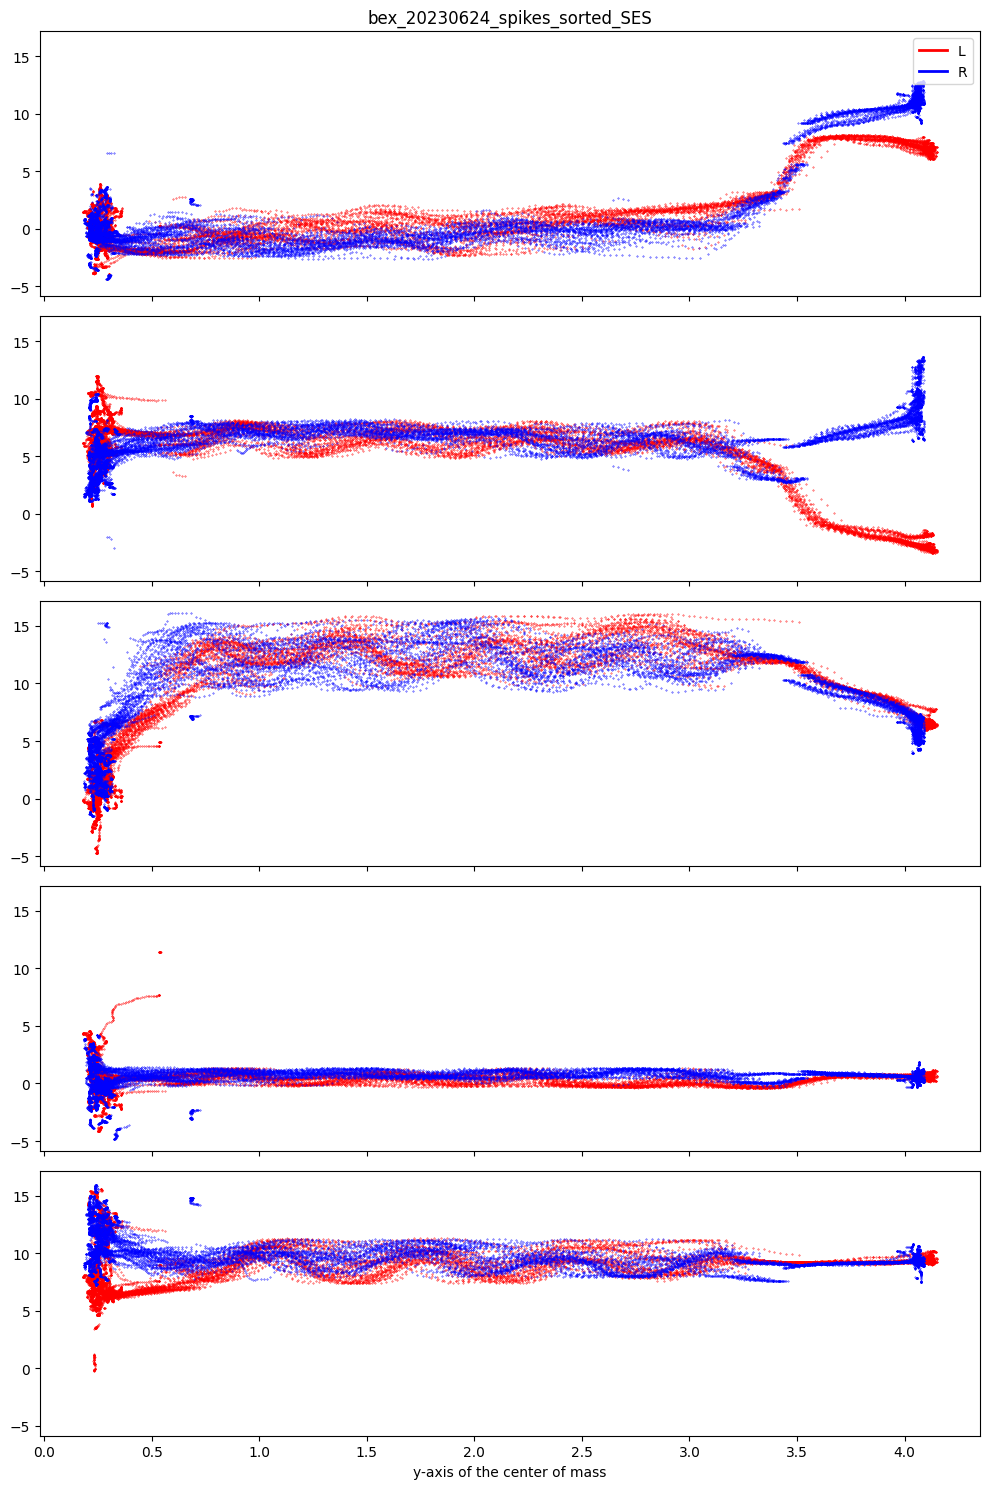

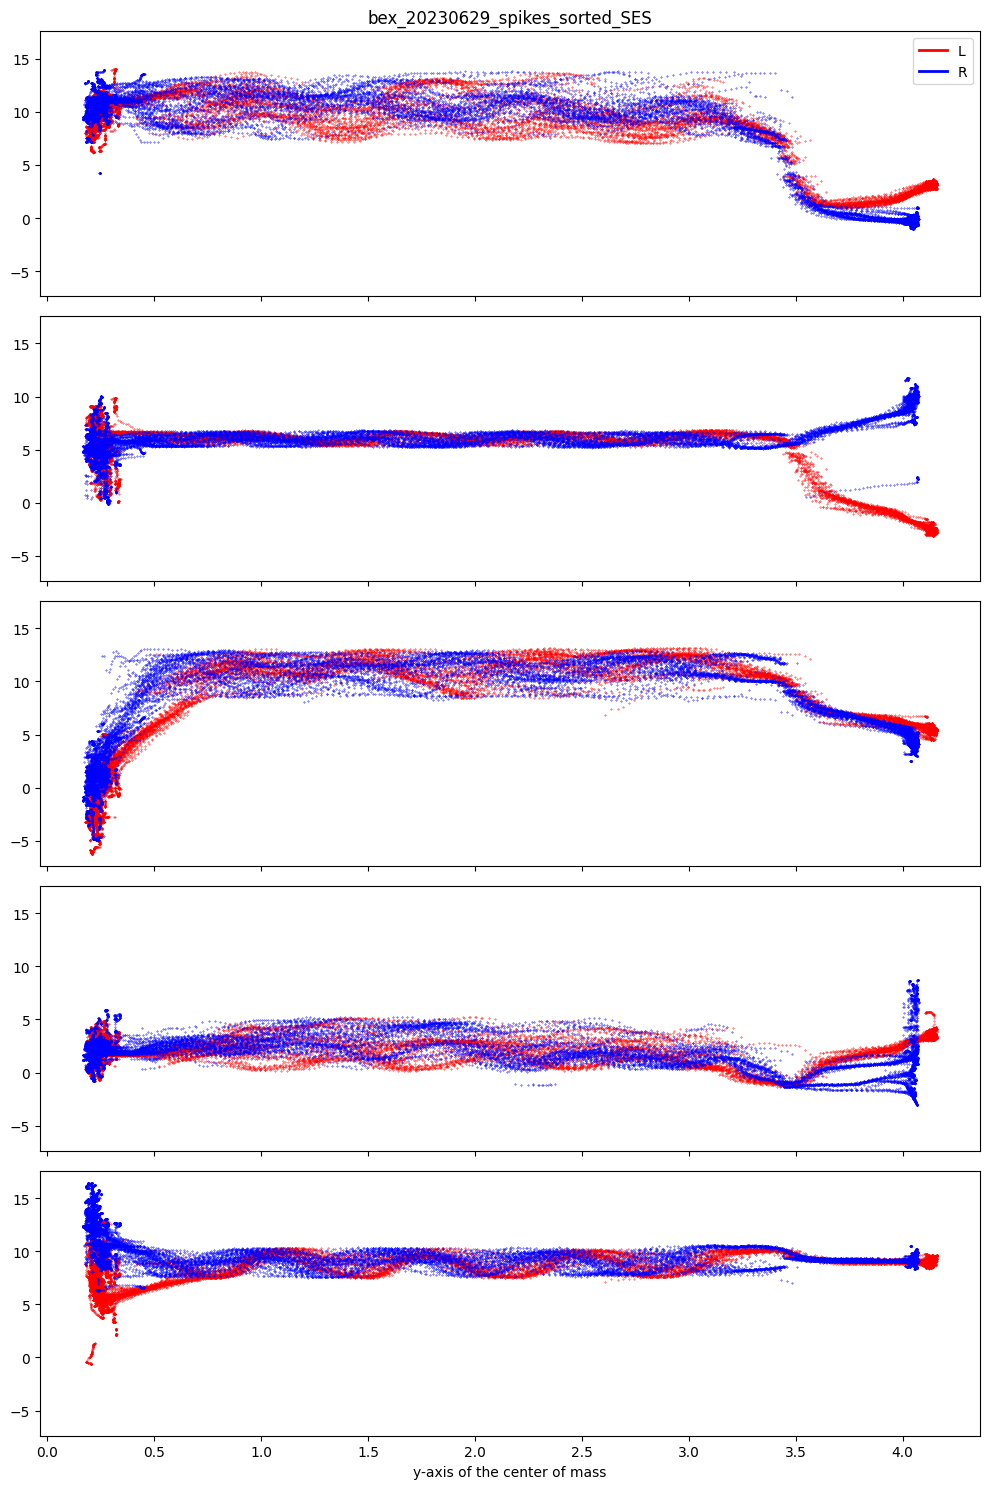

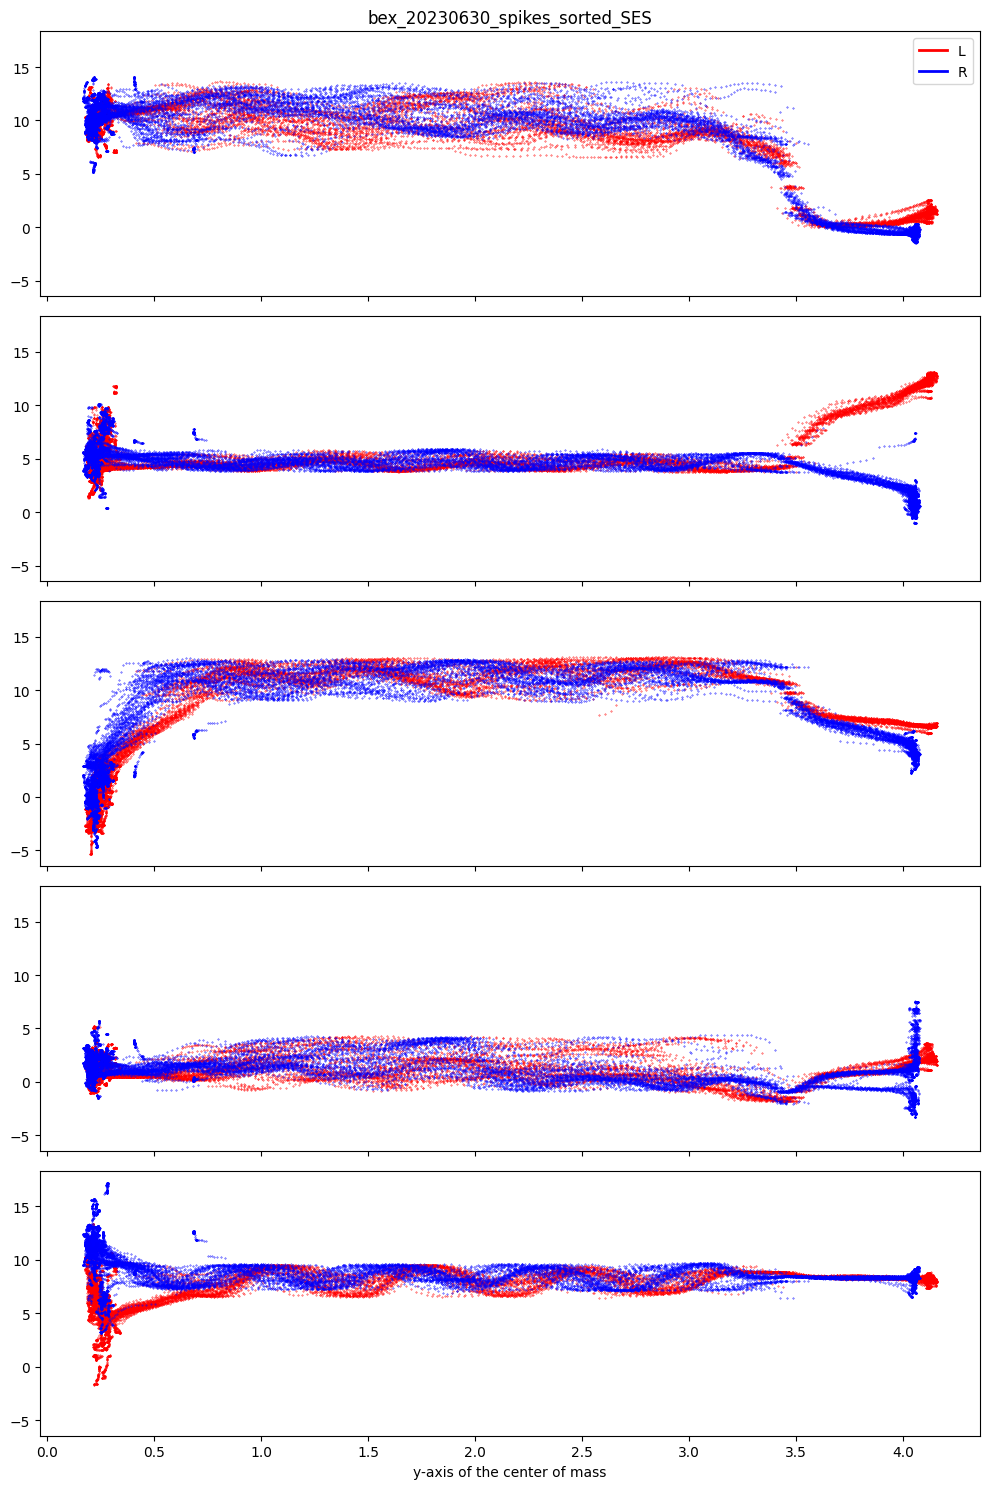

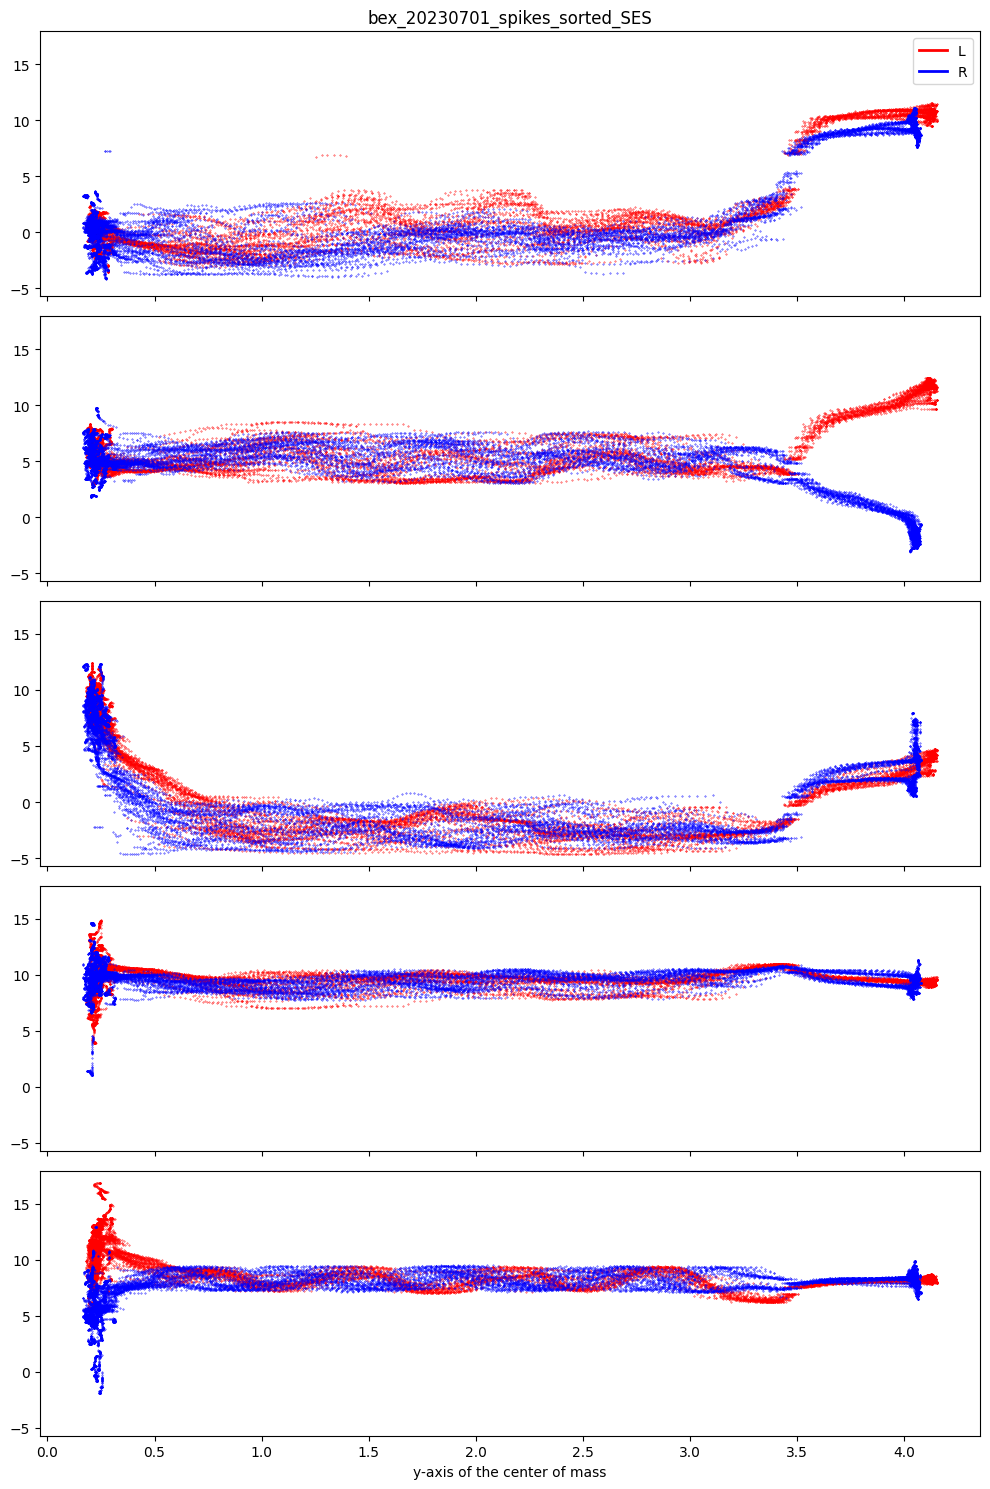

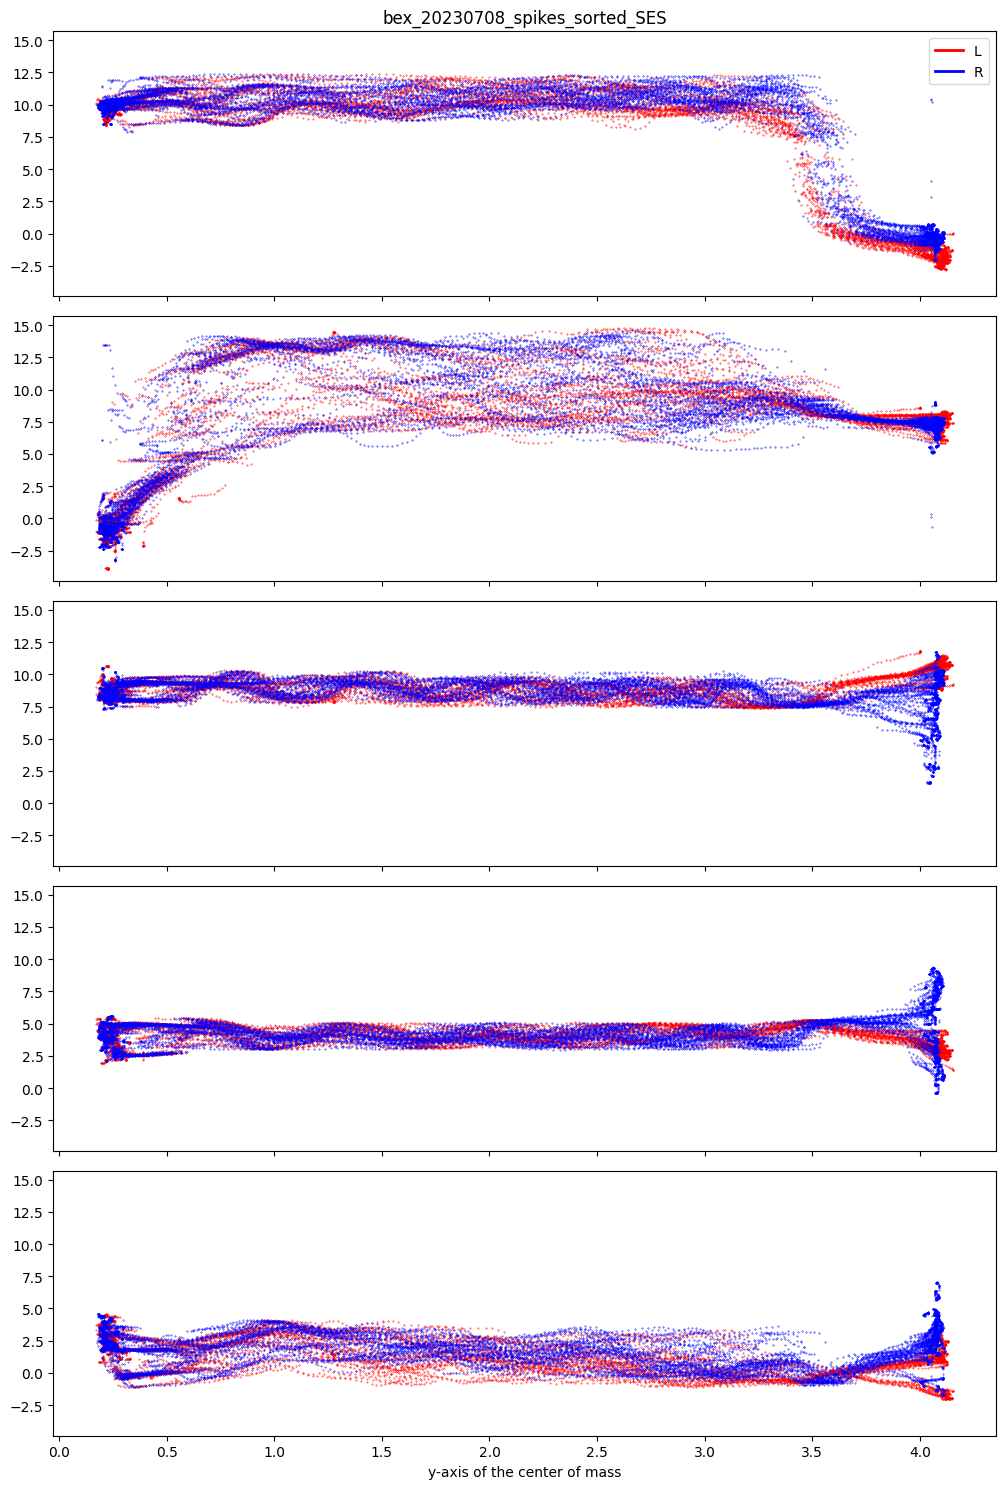

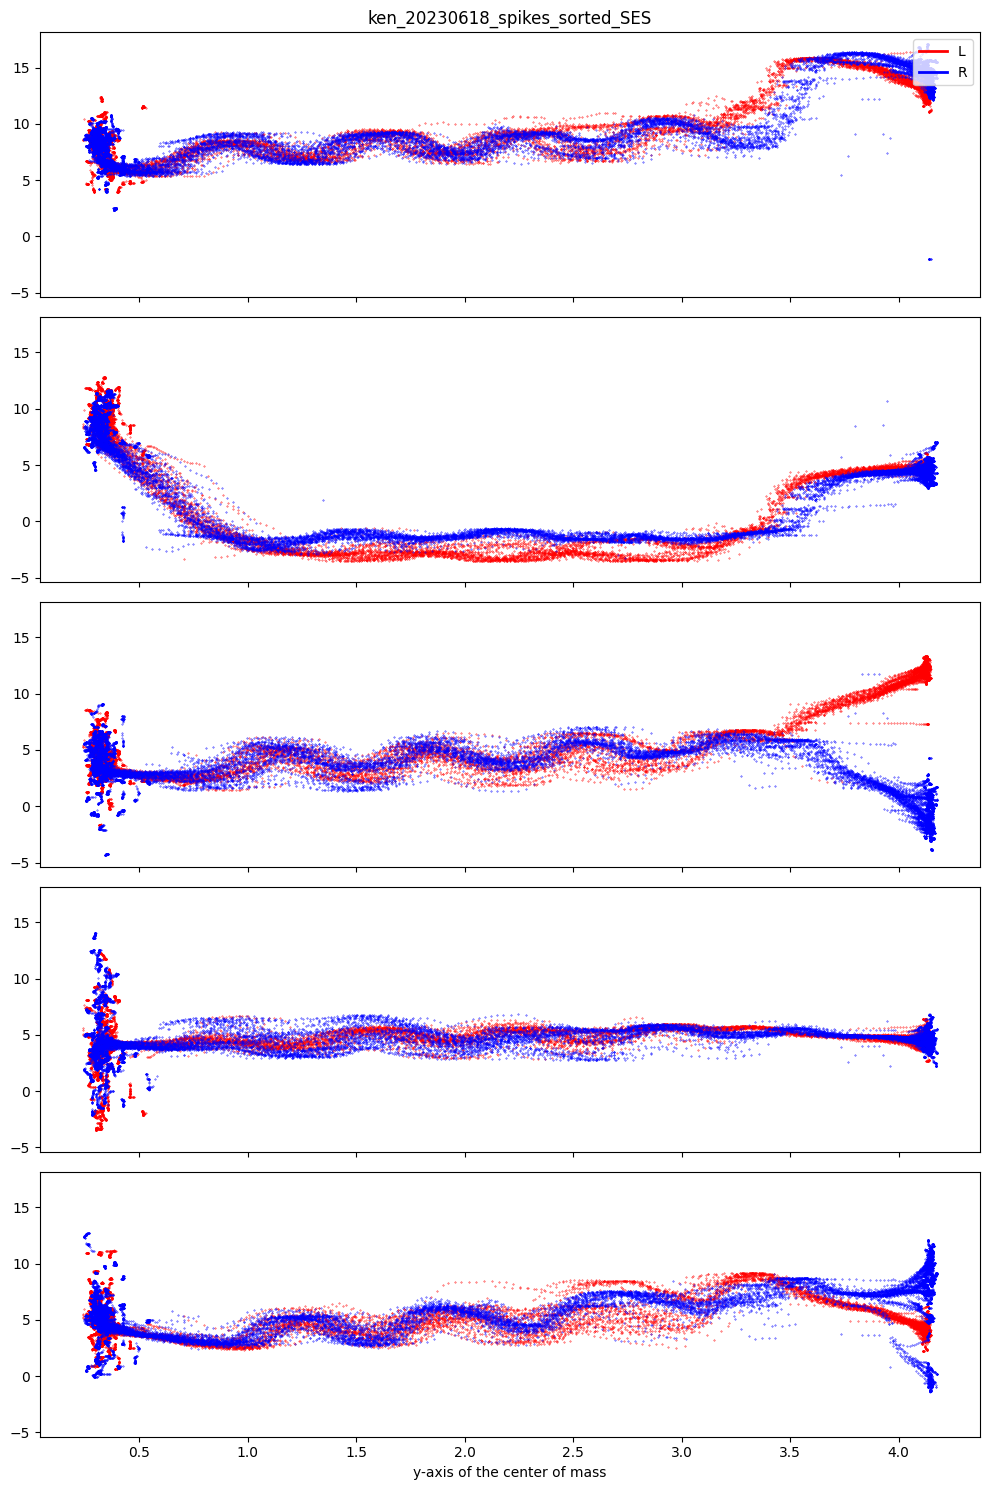

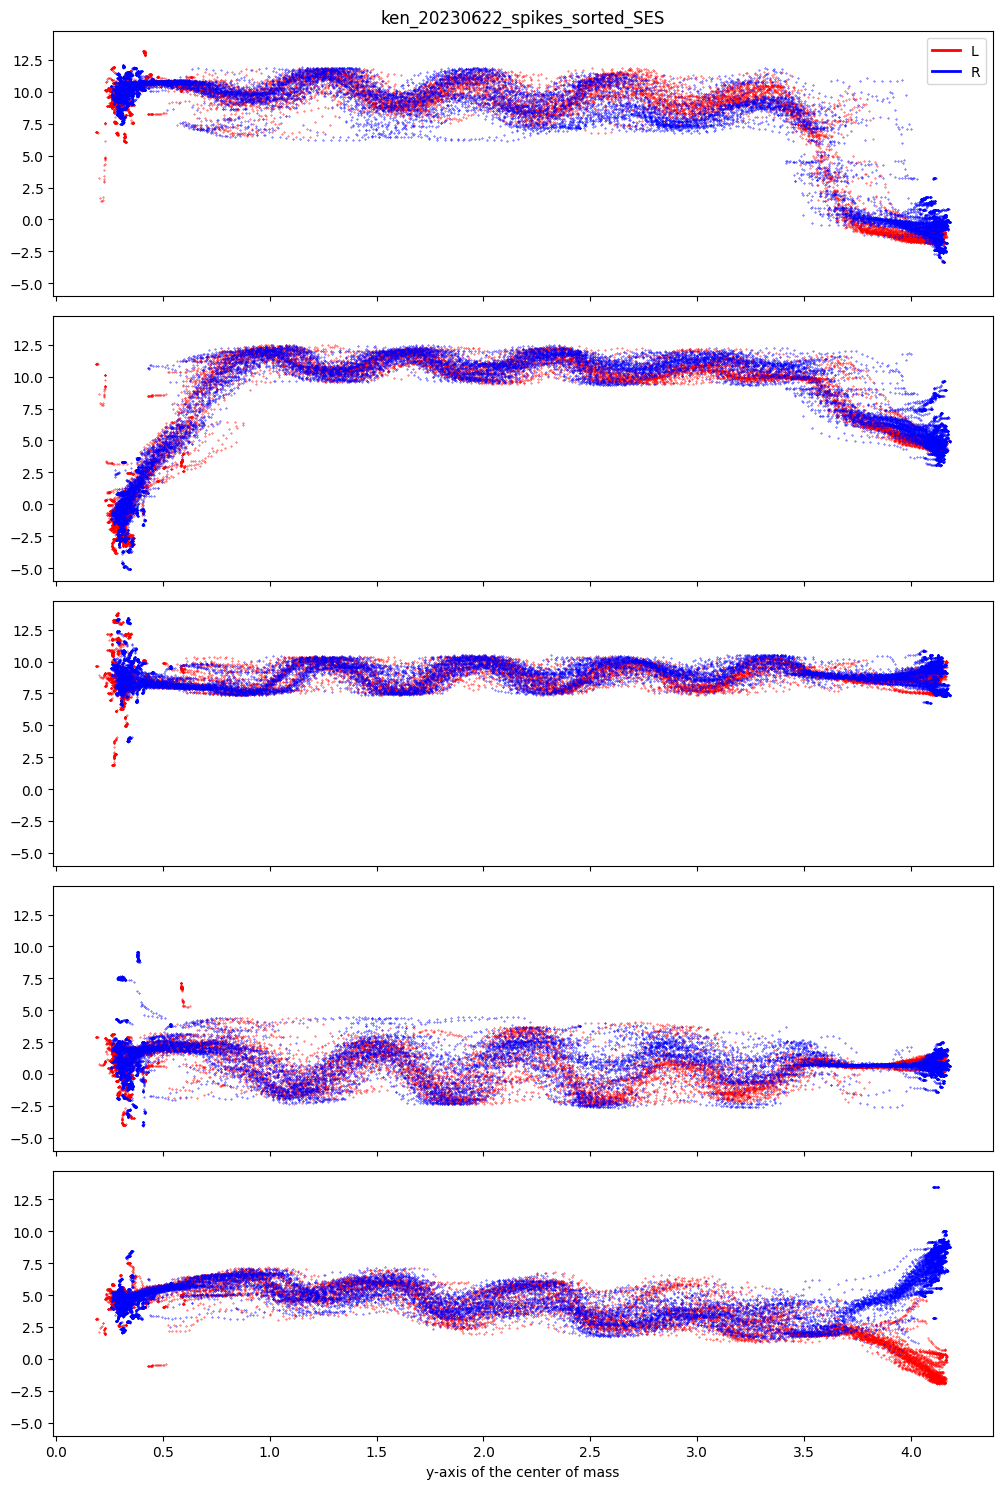

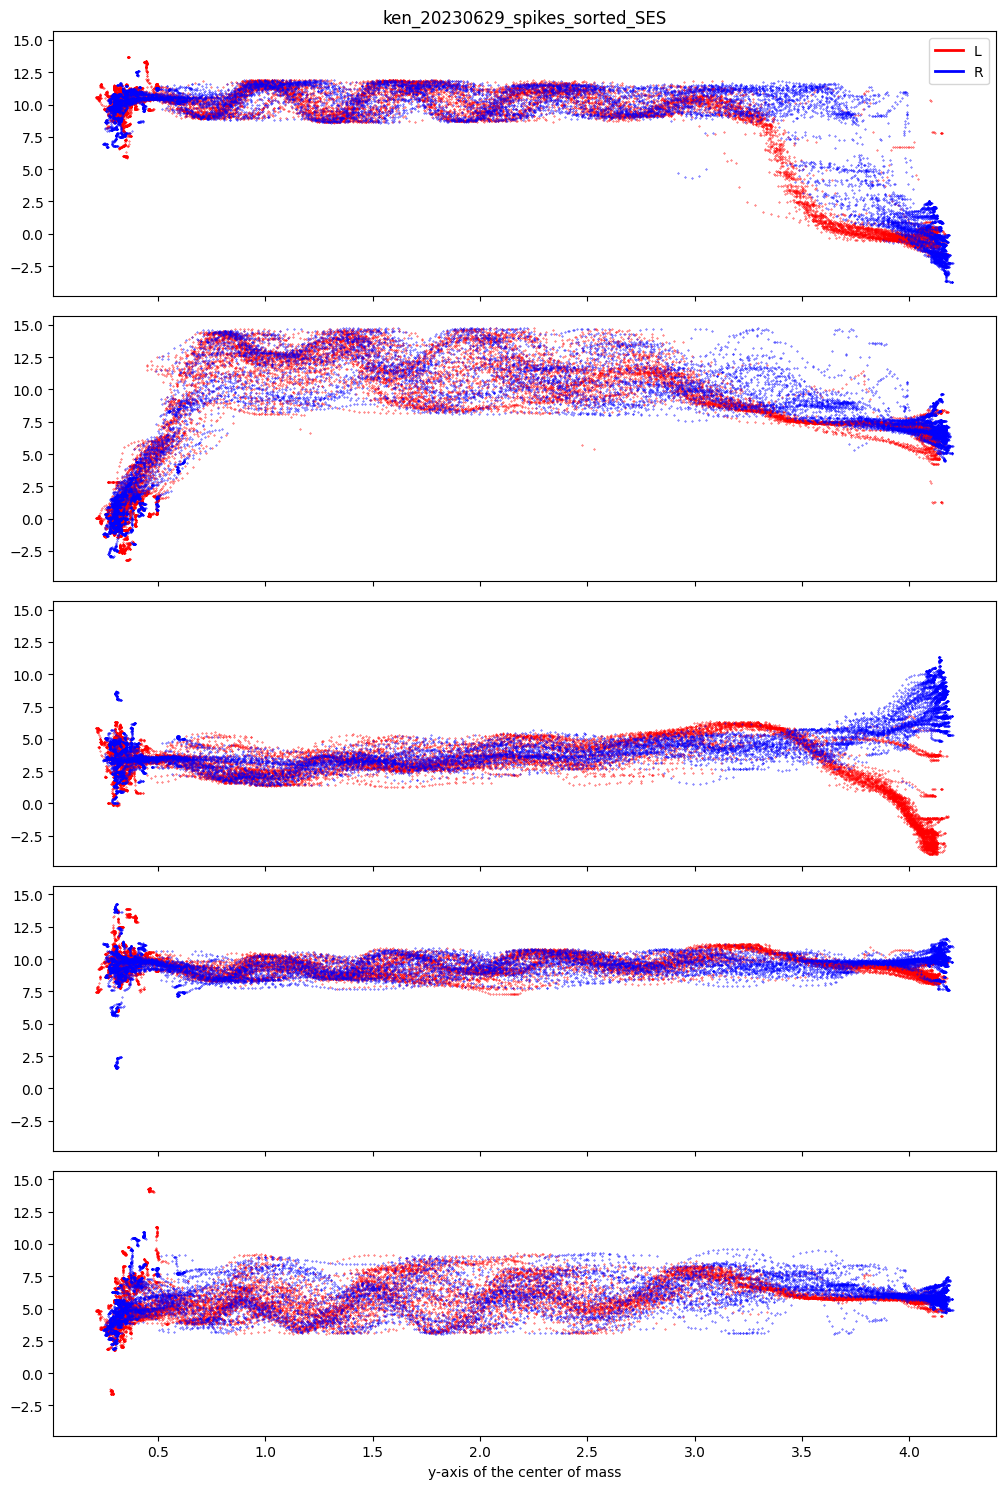

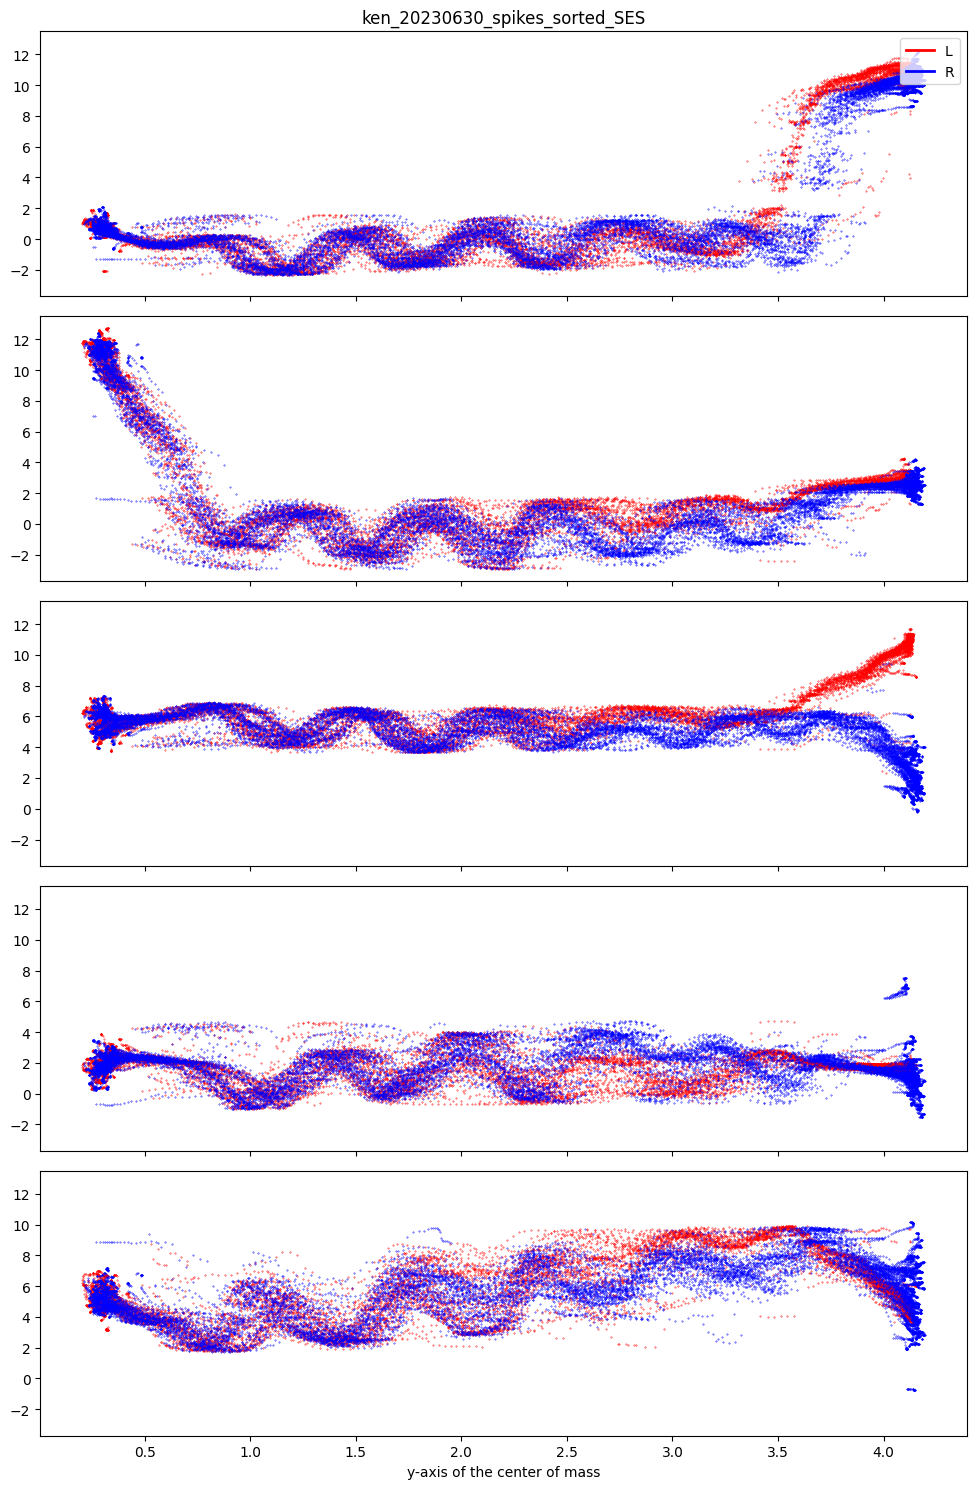

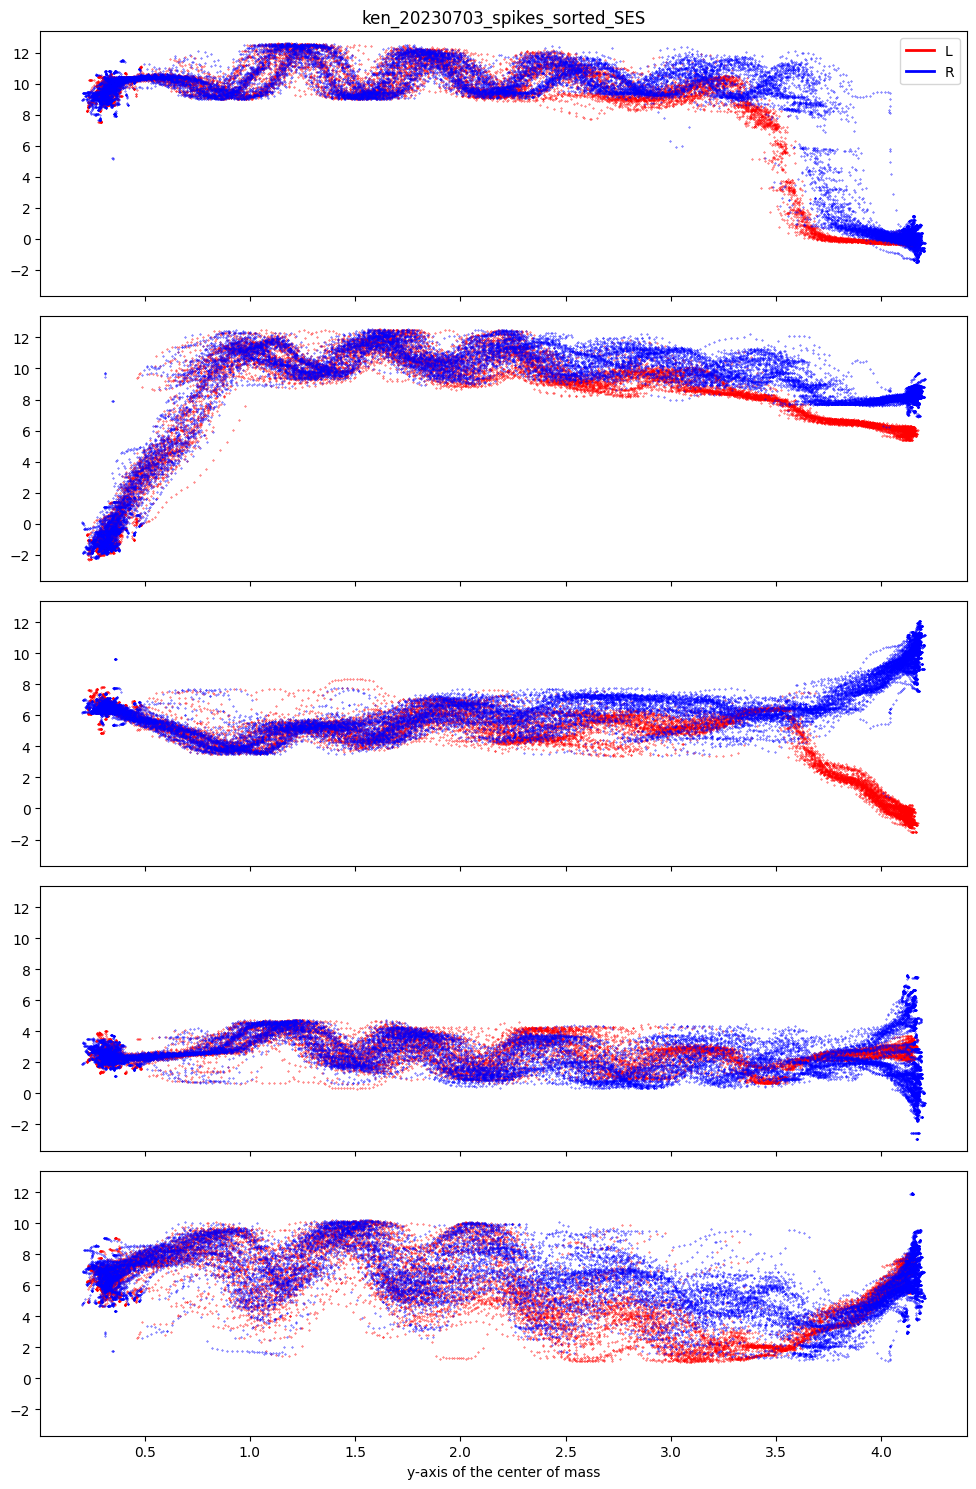

In [72]:
from matplotlib.lines import Line2D

for i, session in enumerate(embeddings):
    fig, ax = plt.subplots(
        n_dims, 1, sharex=True, sharey=True, figsize=(10, n_dims * 3)
    )
    ax[0].set_title(session)
    ax[-1].set_xlabel("y-axis of the center of mass")
    for dim in range(n_dims):
        ax[dim].scatter(
            y_axis_com_stacked[session][: l_limits[session]],
            embeddings[session][: l_limits[session], dim],
            color="red",
            s=0.1,
            label="L",
        )
        ax[dim].scatter(
            y_axis_com_stacked[session][l_limits[session] :],
            embeddings[session][l_limits[session] :, dim],
            color="blue",
            s=0.1,
            label="R",
        )
    custom_lines = [
        Line2D([0], [0], color="red", lw=2, label="L"),
        Line2D([0], [0], color="blue", lw=2, label="R"),
    ]
    ax[0].legend(handles=custom_lines, loc="upper right")
    fig.tight_layout()
    fig.savefig(f"plots/kinematics/umap_{session}.svg")
    plt.show()
    plt.close(fig)

In [ ]:
y_color = y_stack_everything / y_stack_everything.max()
y_color = np.append(
    np.zeros(l_limit), np.ones(len(y_stack_everything) - l_limit)
)

In [ ]:
%matplotlib widget
# Create the trace
trace = go.Scatter3d(
    x=X_embedded[:, 0],  # X coordinates
    y=X_embedded[:, 1],  # Y coordinates
    z=X_embedded[:, 2],  # Z coordinates
    mode="markers",
    marker=dict(size=1.5, color=y_color, opacity=1, colorscale="Plasma"),
)

# Create the layout
layout = go.Layout(
    width=1200,  # 800
    height=800,  # 500
    scene=dict(
        yaxis=dict(
            title="Y",
            backgroundcolor="rgba(0, 0, 0, 1)",
            showgrid=False,
            zeroline=False,
        ),
        xaxis=dict(
            title="X",
            backgroundcolor="rgba(0, 0, 0, 1)",
            showgrid=False,
            zeroline=False,
        ),
        zaxis=dict(
            title="Z",
            backgroundcolor="rgba(0, 0, 0, 1)",
            showgrid=False,
            zeroline=False,
        ),
    ),
    paper_bgcolor="black",  # Set the paper background color to black
    plot_bgcolor="black",  # Set the plot background color to black
    font=dict(color="black"),  # Set the font color to white for visibility
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)
# fig.update_xaxes(showgrid=False, zeroline=False)
# fig.update_yaxes(showgrid=False, zeroline=False)

# Show the figure
fig.show()